# Notebook that predicts characteristics

In [1]:
import os

import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from statistics import mean
import matplotlib
from tqdm import tqdm
from datetime import datetime

import os
from PIL import Image
from sklearn.metrics import accuracy_score
import torchvision
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader, ConcatDataset, SubsetRandomSampler
from torch.optim import lr_scheduler

plt.style.use('seaborn')

import DiagnosisFunctions.tools as tools

import torchvision.models as models

import albumentations as A
import torchvision.transforms.functional as TF
from sklearn.model_selection import KFold
import time
import pickle

import CNNmodels as CNNmodels

In [2]:
#Set the notebook to run on the GPU, if available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'This notebook is running on the {device.type}.')

if device.type == 'cuda':
    print(f"Running on device {torch.cuda.current_device()}")
    print('')

This notebook is running on the cpu.


In [3]:
(train_path, train_target), (test_path, test_target) = tools.get_splits_characteristics()

train_set = tools.CharacteristicsDataset(path = train_path, target = train_target, size = [200, 200])
test_set = tools.CharacteristicsDataset(path = test_path, target = test_target, size = [200, 200])

# Training

In [4]:
class WeightedBCELoss():
    def __init__(self, weights=[1, 1, 1]):
        self.weights = weights
        self.criterion = nn.BCELoss()

    def __call__(self, probabilities, targets):
        loss_characteristics = self.criterion(probabilities[:, :7], targets[:, :7]) 
        loss_diagnosis       = self.criterion(probabilities[:, 7:13], targets[:, 7:13]) 
        loss_area            = self.criterion(probabilities[:, 13:], targets[:, 13:])

        return self.weights[0] * loss_characteristics + self.weights[1] * loss_diagnosis + self.weights[2] * loss_area

In [ ]:
criterion = WeightedBCELoss(weights=[0.41072483896743606, 0.6142489137204648, 0.17056242939212682])
lr = 0.0003213711824536609
train_loader = DataLoader(train_set, batch_size=56)
test_loader = DataLoader(test_set, batch_size=56)

cnn = CNNmodels.CNN2().to(device)
optimizer = optim.Adam(cnn.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_epoch_loss = []
# train
for epoch in tqdm(range(20), unit='Epoch'):
    cnn.train()
    running_loss = 0.0
    
    for inputs, targets, _ in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device).float()

        optimizer.zero_grad()

        outputs = cnn(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
    train_epoch_loss.append(running_loss / len(train_loader.dataset))

In [ ]:
with open('final_model.p', 'wb') as output_model:
    pickle.dump((cnn.to('cpu'), train_epoch_loss), output_model)

In [10]:
with open('final_model.p', 'rb') as input_model:
    model_file = pickle.load(input_model)

In [28]:
test_epoch_loss = []
# test
for epoch in tqdm(range(20), unit='Epoch'):
    cnn.eval()
    running_loss = 0.0
    
    for inputs, targets, _ in test_loader:
        inputs = inputs
        targets = targets.float()

        optimizer.zero_grad()

        outputs = cnn(inputs)
        loss = criterion(outputs, targets)

        # loss.backward()
        # optimizer.step()
        # scheduler.step()
        
        running_loss += loss.item()
        print(loss.item())
    test_epoch_loss.append(running_loss / len(test_loader.dataset))

  0%|          | 0/20 [00:00<?, ?Epoch/s]

0.6573482155799866


  5%|▌         | 1/20 [00:09<02:57,  9.36s/Epoch]

0.6533468961715698
0.6573482155799866


 10%|█         | 2/20 [00:18<02:43,  9.11s/Epoch]

0.6533468961715698
0.6573482155799866


 15%|█▌        | 3/20 [00:26<02:30,  8.83s/Epoch]

0.6533468961715698
0.6573482155799866


 20%|██        | 4/20 [00:35<02:20,  8.81s/Epoch]

0.6533468961715698


 20%|██        | 4/20 [00:35<02:23,  8.97s/Epoch]


KeyboardInterrupt: 

In [ ]:
with open('final_model.p', 'wb') as output_model:
    pickle.dump((cnn.to('cpu'), (train_epoch_loss, test_epoch_loss)), output_model)

In [17]:
with open('final_model.p', 'rb') as input_model:
    input_model_files = pickle.load(input_model)

In [23]:
train_loss = input_model_files[1][0]
test_loss = input_model_files[1][1]

In [25]:
test_loss

[0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025,
 0.013325678296836025]

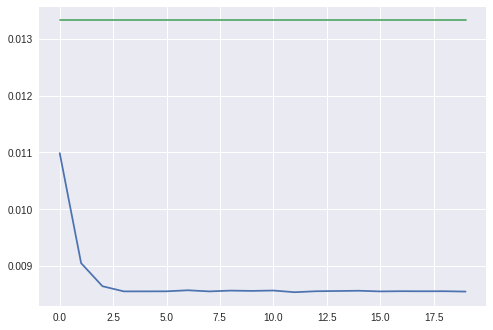

In [24]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()